In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gen_frac_diff_trajectories import fractional_diffusion
from scipy.io import loadmat
from scipy.special import gamma
from numpy import cos, sin, pi
# from utils import estimate_frac_diff_2
from utils import *
from tqdm import tqdm

# Generate artificial trajectories

In [2]:
alpha_ = 2;beta_ = 1;theta_ = 0;D_ = 1;L = 1e3;M = int(1e4)

In [3]:
traj = fractional_diffusion(alpha_, beta_, theta_, D_, L, M, use_parallel=True, do_save=False)

### It is recommended to use Matlab generated simulated trajectories
### The data is generated using matlab/gen_sim_data.m
### In Matlab do:
```
>>gen_sim_data(alpha_, beta_, theta_, D_, L, M, true);
```

In [4]:
# data_raw = loadmat('matlab/data/sim_D_1.00_A_2.00_B_1.00_theta_0.00_N_30000_M_10000_L_1000.mat')
# traj = {'x':data_raw['xnt'], 'T':np.squeeze(data_raw['T'])}

In [5]:
delta_use = 0.001
moment_p = np.mean(np.power(np.abs(traj['x']), delta_use), axis=1)
moment_p_ther = np.power(traj['T'], delta_use*beta_/alpha_)*(gamma(1 - delta_use/alpha_) * gamma(1 + delta_use/alpha_)
                                                            *cos(np.pi*delta_use*theta_/2/alpha_)/gamma(1 - delta_use)
                                                            /gamma(1 + delta_use*beta_/alpha_)/cos(delta_use*pi/2))

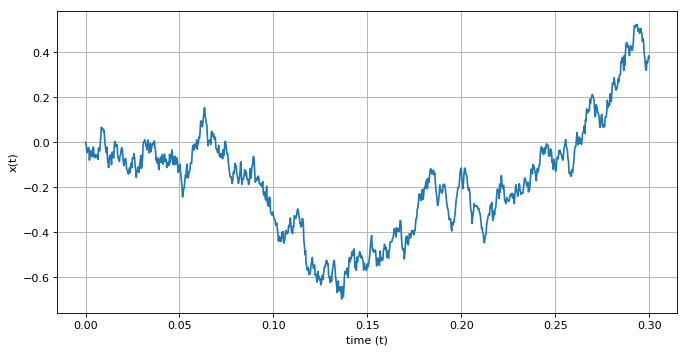

In [7]:
# plot a sample trajectory
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(traj['T'], traj['x'][:,90])
plt.xlabel('time (t)')
plt.ylabel('x(t)')
plt.grid()
plt.show()

# Estimate fractional diffusion PDE parameters
## Approach-1 (using sinc inverse)

In [8]:
is_feasible, alpha_hat, beta_hat, theta_hat, D_hat = estimate_frac_diff_absm(traj['x'], traj['T'])
if is_feasible:
    print('Estimated values of (alpha, beta, theta, D) = (%f, %f, %f, %f)'%(alpha_hat, beta_hat, theta_hat, D_hat))

Estimated values of (alpha, beta, theta, D) = (1.995914, 0.998261, -0.003847, 0.988630)


## Approach-2 (using log covariates)

In [9]:
is_feasible, alpha_hat, beta_hat, theta_hat, D_hat = estimate_frac_diff_logm(traj['x'], traj['T'])
if is_feasible:
    print('Estimated values of (alpha, beta, theta, D) = (%f, %f, %f, %f)'%(alpha_hat, beta_hat, theta_hat, D_hat))

Estimated values of (alpha, beta, theta, D) = (1.995835, 0.998222, -0.003847, 0.988418)


### We now study the behavior of both the Algorithms with varying number of trajectories

In [10]:
%%time
# THIS MIGHT TAKE COUPLE OF HOURS TO FINISH...

time_len = 1000
num_points = 200
num_traj_total = int(1e4)
XNT, T = traj['x'], traj['T']
# [XNT, T] = gen_sim_data(alpha, beta, theta, D, time_len, num_traj_total, false);
# M_try = np.floor(np.logspace(0, np.log10(M), num_trials)).astype('int')
num_traj = np.floor(np.logspace(1, 4, 35)).astype('int')
ALPHA_1 = np.zeros((np.size(num_traj), num_points))
BETA_1 = np.zeros_like(ALPHA_1)
THETA_1 = np.zeros_like(ALPHA_1)
D_1 = np.zeros_like(ALPHA_1)

ALPHA_2 = np.zeros_like(ALPHA_1)
BETA_2 = np.zeros_like(ALPHA_1)
THETA_2 = np.zeros_like(ALPHA_1)
D_2 = np.zeros_like(ALPHA_1)

max_try = 20
for p in tqdm(range(num_points)):
    for t in range(np.size(num_traj)):
        successful_run = False
        ctr = 0
        while(ctr<max_try):
            random_traj_index = np.random.choice(num_traj_total, num_traj[t]).astype('int')
            xnt_use = XNT[:,random_traj_index]
            is_feasible_absm, alpha_hat_1, beta_hat_1, theta_hat_1, D_hat_1 = \
                                            estimate_frac_diff_absm(xnt_use, traj['T'])
            is_feasible_logm, alpha_hat_2, beta_hat_2, theta_hat_2, D_hat_2 = \
                                            estimate_frac_diff_logm(xnt_use, traj['T'])
            
            if is_feasible_absm and is_feasible_logm:
                ALPHA_1[t,p],BETA_1[t,p],THETA_1[t,p],D_1[t,p] = \
                                    alpha_hat_1, beta_hat_1, theta_hat_1, D_hat_1
                ALPHA_2[t,p],BETA_2[t,p],THETA_2[t,p],D_2[t,p] = \
                                    alpha_hat_2, beta_hat_2, theta_hat_2, D_hat_2
#                 print('Completed for tuple (p, t) = (%d, %d)'%(p, t))

                break
            else:
                ctr += 1
            if ctr == max_try:
                print('Error not terminated due to less number of trajectories, try to use more...\n')

100%|██████████| 200/200 [7:43:57<00:00, 139.19s/it]  

CPU times: user 14h 21min 22s, sys: 2h 37min 17s, total: 16h 58min 39s
Wall time: 7h 43min 57s


In [12]:
param_fin_absm = np.stack((ALPHA_1, BETA_1, THETA_1, D_1))
param_fin_logm = np.stack((ALPHA_2, BETA_2, THETA_2, D_2))
param_fin = np.stack((param_fin_absm, param_fin_logm))

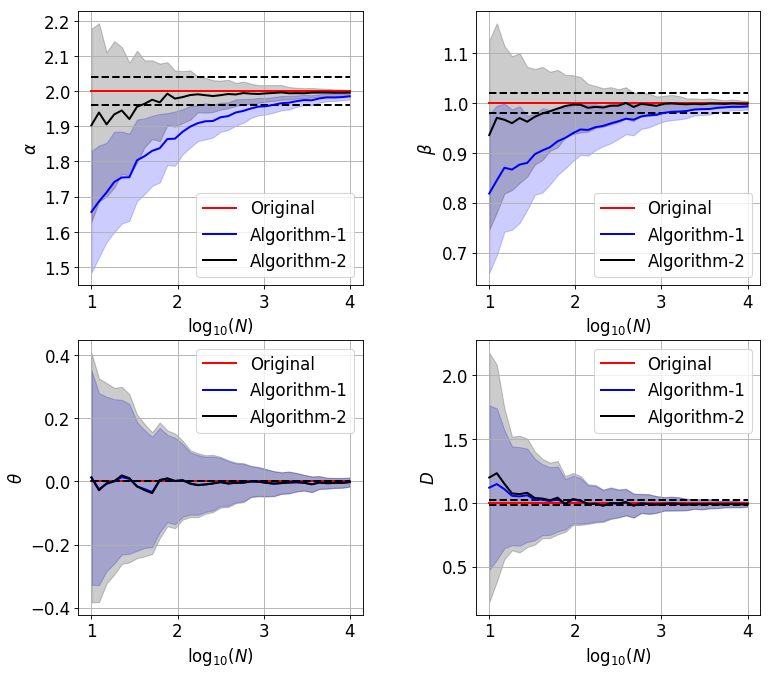

In [16]:
color = ['b', 'k', 'r', 'goldenrod', 'k', 'm' , 'xkcd:Purple', 'C1', 'C2', 'xkcd:Brown', 'xkcd:navy blue', 'k']
linestyle = ['solid', 'solid', 'solid', 'solid', 'dashed', 'solid']

f = plt.figure(figsize=(11,10), dpi=80)
# f = plt.figure(figsize=(17,10), dpi=80)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)
legend_name = ['Algorithm-1','Algorithm-2', 'Algo-2-mgf']
frac_param_list = ['alpha', 'beta', 'theta', 'D']
y_label_list = [r'$\alpha$', r'$\beta$', r'$\theta$', r'$D$']
ax_all = []
x = np.linspace(1, np.log10(M), 35)
plt.subplots_adjust(wspace= 0.4)
params_orig = np.array([alpha_, beta_, theta_, D_])
for i, param_name in enumerate(frac_param_list):
    ax_curr = plt.subplot(2, 2, i+1)
    ax_all.append(ax_curr)
    plt.plot(x, np.ones((np.size(x),))*params_orig[i], color='r', linewidth = 1.8, label = 'Original')
    plt.plot(x, np.ones((np.size(x),))*params_orig[i]*1.02, color='k', linewidth = 1.8, linestyle = 'dashed')
    plt.plot(x, np.ones((np.size(x),))*params_orig[i]*0.98, color='k', linewidth = 1.8, linestyle = 'dashed')
    plt.xlabel('$\log_{10}(N)$', fontsize=15)
    plt.ylabel(y_label_list[i], fontsize=15)

for j, frac_param in enumerate(frac_param_list):
    plt.sca(ax_all[j])
    for aa in range(2):
        y_mean = np.mean(param_fin[aa,j,:,:],axis=1)
        y_std = np.std(param_fin[aa,j,:,:],axis=1)
        p = ax_all[j].plot(x, y_mean, color = color[aa], linewidth = 1.8, label = legend_name[aa])
        plt.fill_between(x, y_mean - y_std, y_mean + y_std, color = p[0].get_color(), alpha = 0.2)
    plt.grid()
    plt.legend()
plt.show()